In [ ]:
#!pip install https://github.com/google-research/perceptual-quality/archive/master.zip

     - 0 bytes ? 0:00:00
     \ 45.3 kB 466.5 kB/s 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   --- ------------------------------------ 0.5/7.0 MB 4.2 MB/s eta 0:00:02
   ------ --------------------------------- 1.0/7.0 MB 3.4 MB/s eta 0:00:02
   ---------- ----------------------------- 1.8/7.0 MB 3.5 MB/s eta 0:00:02
   ------------- -------------------------- 2.4/7.0 MB 3.4 MB/s eta 0:00:02
   ------------------- -------------------- 3.4/7.0 MB 3.5 MB/s eta 0:00:02
   ---------------------- ----------------- 3.9/7.0 MB 3.5 MB/s eta 0:00:01
   --------------------------- ------------ 4.7/7.0 MB 3.4 MB/s eta 0:00:01
   ------------------------------ --------- 5.2/7.0 MB 3.3 MB/s eta 0:00:01
   ---------------------------------- ----- 6.0/7.0 MB 3.4 MB/s eta 0:00:01
   ---------------------------------------  6.8/7.0 MB 3.4 MB/s eta 0:00:01
   -------


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
from LoadingDefault import LoadData

from torch import nn
import torch.optim as optim
from torchinfo import summary

import torch
import torch.nn.functional as F

#from perceptual_quality.nlpd import nlpd
import numpy as np
import tensorflow as tf

c:\Users\jpeir\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
dataloader = LoadData(limit=100, batch_size=8)

c:\Users\jpeir\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


In [3]:
class EntropyLimitedAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.centers = torch.Tensor([-1, 1])
        self.sigma = 10
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=128, kernel_size=3, stride=2, padding=1),  # Reduce tamaño a 128x128
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1),  # Reduce tamaño a 128x128
            nn.BatchNorm2d(128),
            nn.Tanh()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=128, out_channels=1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )


    def encode(self, x):
        y = self.encoder(x)
        return y

    
    def quantise(self, y):
        if self.centers is None:
            return y
        y_flat = y.reshape(y.size(0), y.size(1), y.size(2)*y.size(3), 1)
        dist = torch.abs((y_flat - self.centers))**2
        if self.train:
            phi = F.softmax(-self.sigma * dist, dim=-1)
        else:
            phi = F.softmax(-1e7 * dist, dim=-1)
            symbols_hard = torch.argmax(phi, axis=-1)
            phi = F.one_hot(symbols_hard, num_classes=self.centers.size(0))
        inner_product = phi * self.centers
        y_hat = torch.sum(inner_product, axis=-1)
        y_hat = y_hat.reshape(y.shape)
        return y_hat
    

    def decode(self, y):
        x = self.decoder(y)
        return x
    

    def forward(self, x):
        encoded = self.encode(x)
        limit_entropy = self.quantise(encoded)
        decoded = self.decode(limit_entropy)
        return decoded

In [4]:
def format(x):
    return tf.convert_to_tensor(np.transpose((x)*255, (1, 2, 0)))

class NLPDLoss(nn.Module):
    def __init__(self, num_levels=6):
        """
        Implementación de la pérdida Normalized Laplacian Pyramid Distance (NLPD)
        como criterio de entrenamiento para un autoencoder.

        num_levels: Número de niveles en la pirámide Laplaciana.
        """
        super(NLPDLoss, self).__init__()
        self.num_levels = num_levels

    def forward(self, reconstructed, original):
        """
        Calcula la pérdida NLPD entre la imagen original y la reconstruida.

        original: Tensor de PyTorch con la imagen original.
        reconstructed: Tensor de PyTorch con la imagen reconstruida.

        Retorna: Valor escalar de la pérdida NLPD.
        """
        batch_size = original.shape[0]
        total_loss = 0.0

        for i in range(batch_size):
            # Convertir a numpy
            # original_np = original[i].detach().cpu().numpy()
            # reconstructed_np = reconstructed[i].detach().cpu().numpy()

            total_loss += nlpd(format(original[i].detach().numpy()),
                               format(reconstructed[i].detach().numpy()),
                               num_levels = self.num_levels).numpy()
        return torch.tensor(total_loss / batch_size, requires_grad=True)

In [6]:
ae = EntropyLimitedAutoencoder()
criterion = NLPDLoss()
optimizer = optim.AdamW(ae.parameters(), lr=1e-3, weight_decay=1e-4)
#summary(ae)

In [18]:
num_epochs = 3

iter = 0

for epoch in range(num_epochs):
    total_loss = 0
    for batch in dataloader:  # dataloader ya tiene los batches de 64x1x256x256
        batch = batch[0] # Extraer tensor

        optimizer.zero_grad()  # Reiniciar gradientes

        outputs = ae(batch)  # Forward pass
        loss = criterion(outputs, batch)  # Comparar con entrada

        loss.backward()  # Backpropagation
        optimizer.step()  # Actualizar pesos

        total_loss += loss.item()
        print(f"Pérdida: {loss.item():.6f}")

        iter +=1
        if iter > 3:
            break

    avg_loss = total_loss / len(dataloader)
    print(f"Época [{epoch+1}/{num_epochs}], Pérdida: {avg_loss:.6f}")

Pérdida: 0.603115
Pérdida: 0.603107
Pérdida: 0.579964
Pérdida: 0.603972
Época [1/3], Pérdida: 0.095606
Pérdida: 0.584483
Época [2/3], Pérdida: 0.023379
Pérdida: 0.599777
Época [3/3], Pérdida: 0.023991


c:\Users\jpeir\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


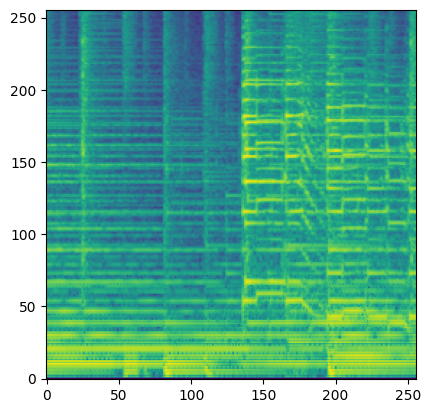

In [8]:
import matplotlib.pyplot as plt
from LoadingDefault import LoadAudios

XX, _= LoadAudios(limit = 5)
plt.imshow(XX[3],origin='lower')

torch.Size([1, 1, 256, 256])
torch.Size([256, 256])


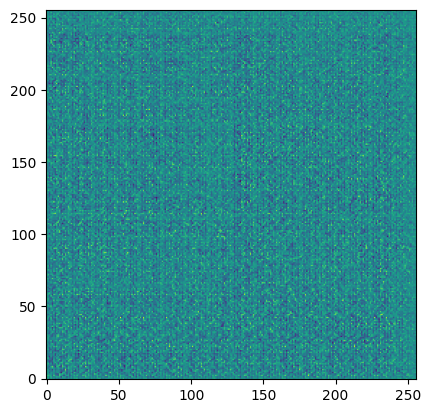

In [ ]:
print(torch.stack([XX[3]]).unsqueeze(1).shape)
aaa = ae.decode(ae.encode(torch.stack([XX[3]]).unsqueeze(1)))
print(aaa[0][0].shape)
plt.imshow(aaa[0][0].detach().numpy(),origin='lower')

In [69]:
LAPLACIAN_FILTER = np.array([[0.0025, 0.0125, 0.0200, 0.0125, 0.0025],
                             [0.0125, 0.0625, 0.1000, 0.0625, 0.0125],
                             [0.0200, 0.1000, 0.1600, 0.1000, 0.0200],
                             [0.0125, 0.0625, 0.1000, 0.0625, 0.0125],
                             [0.0025, 0.0125, 0.0200, 0.0125, 0.0025]],
                            dtype=np.float32)


class LaplacianPyramid(nn.Module):
    def __init__(self, k, dims=3, filt=None, trainable=False):
        super(LaplacianPyramid, self).__init__()
        if filt is None:
            filt = np.reshape(np.tile(LAPLACIAN_FILTER, (dims, 1, 1)),
                              (dims, 1, 5, 5))
        self.k = k
        self.trainable = trainable
        self.dims = dims
        self.filt = nn.Parameter(torch.Tensor(filt), requires_grad=False)
        self.dn_filts, self.sigmas = self.DN_filters()

    def DN_filters(self):
        sigmas = [0.0248, 0.0185, 0.0179, 0.0191, 0.0220, 0.2782]
        dn_filts = []
        dn_filts.append(torch.Tensor(np.reshape([[0, 0.1011, 0],
                                                 [0.1493, 0, 0.1460],
                                                 [0, 0.1015, 0.]]*self.dims,
                                                (self.dims,  1, 3, 3)).astype(np.float32)))

        dn_filts.append(torch.Tensor(np.reshape([[0, 0.0757, 0],
                                                 [0.1986, 0, 0.1846],
                                                 [0, 0.0837, 0]]*self.dims,
                                                (self.dims, 1, 3, 3)).astype(np.float32)))

        dn_filts.append(torch.Tensor(np.reshape([[0, 0.0477, 0],
                                                 [0.2138, 0, 0.2243],
                                                 [0, 0.0467, 0]]*self.dims,
                                                (self.dims, 1, 3, 3)).astype(np.float32)))

        dn_filts.append(torch.Tensor(np.reshape([[0, 0, 0],
                                                 [0.2503, 0, 0.2616],
                                                 [0, 0, 0]]*self.dims,
                                                (self.dims, 1, 3, 3)).astype(np.float32)))

        dn_filts.append(torch.Tensor(np.reshape([[0, 0, 0],
                                                 [0.2598, 0, 0.2552],
                                                 [0, 0, 0]]*self.dims,
                                                (self.dims, 1, 3, 3)).astype(np.float32)))

        dn_filts.append(torch.Tensor(np.reshape([[0, 0, 0],
                                                 [0.2215, 0, 0.0717],
                                                 [0, 0, 0]]*self.dims,
                                                (self.dims, 1, 3, 3)).astype(np.float32)))
        dn_filts = nn.ParameterList([nn.Parameter(x, requires_grad=self.trainable)
                                     for x in dn_filts])
        sigmas = nn.ParameterList([nn.Parameter(torch.Tensor(np.array(x)),
                                                requires_grad=self.trainable) for x in sigmas])
        return dn_filts, sigmas

    def pyramid(self, im):
        import conv_utils

        out = []
        J = im
        pyr = []
        for i in range(0, self.k):
            J_padding_amount = conv_utils.pad([J.size(2), J.size(3)],
                                              self.filt.size(3), stride=2)
            I = F.conv2d(F.pad(J, J_padding_amount, mode='reflect'), self.filt,
                         stride=2, padding=0, groups=self.dims)
            I_up = F.interpolate(I, size=[J.size(2), J.size(3)],
                                 align_corners=True, mode='bilinear')
            I_padding_amount = conv_utils.pad([I_up.size(2), I_up.size(3)],
                                              self.filt.size(3), stride=1)
            I_up_conv = F.conv2d(F.pad(I_up, I_padding_amount, mode='reflect'),
                                 self.filt, stride=1, padding=0,
                                 groups=self.dims)
            out = J - I_up_conv
            out_padding_amount = conv_utils.pad(
                [out.size(2), out.size(3)], self.dn_filts[i].size(2), stride=1)
            out_conv = F.conv2d(
                F.pad(torch.abs(out), out_padding_amount, mode='reflect'),
                self.dn_filts[i],
                stride=1,
                groups=self.dims)
            out_norm = out / (self.sigmas[i]+out_conv)
            pyr.append(out_norm)
            J = I
        return pyr
    
    def compare(self, x1, x2):
        y1 = self.pyramid(x1)
        y2 = self.pyramid(x2)
        total = []
        # Calculate difference in perceptual space (Tensors are stored
        # strangley to avoid needing to pad tensors)
        for z1, z2 in zip(y1, y2):
            diff = (z1 - z2) ** 2
            sqrt = torch.sqrt(torch.mean(diff, (1, 2, 3)))
            total.append(sqrt)
        return torch.norm(torch.stack(total), 0.6)


In [76]:
class NLPDLossDEF(nn.Module):
    def __init__(self):
        super(NLPDLossDEF, self).__init__()
        self.lp = LaplacianPyramid(5, dims=1)
    def forward(self, reconstructed, original):
        return self.lp.compare(reconstructed, original)

In [80]:

ae = EntropyLimitedAutoencoder()
criterion = NLPDLossDEF()
optimizer = optim.AdamW(ae.parameters(), lr=1e-3, weight_decay=1e-4)

num_epochs = 3

for epoch in range(num_epochs):
    total_loss = 0
    for batch in dataloader:  # dataloader ya tiene los batches de 64x1x256x256
        batch = batch[0] # Extraer tensor

        optimizer.zero_grad()  # Reiniciar gradientes

        outputs = ae(batch)  # Forward pass
        loss = criterion(outputs, batch)  # Comparar con entrada

        loss.backward()  # Backpropagation
        optimizer.step()  # Actualizar pesos

        total_loss += loss.item()
        print(f"Pérdida: {loss.item():.6f}")

    avg_loss = total_loss / len(dataloader)
    print(f"Época [{epoch+1}/{num_epochs}], Pérdida: {avg_loss:.6f}")

Pérdida: 568.635193
Pérdida: 687.872925
Pérdida: 564.241455
Pérdida: 493.755981
Pérdida: 459.064758
Pérdida: 421.995880
Pérdida: 403.940308
Pérdida: 453.700195
Pérdida: 395.693665
Pérdida: 376.104980
Pérdida: 359.195099
Pérdida: 379.992065
Pérdida: 357.784851
Pérdida: 337.533173
Pérdida: 336.098206
Pérdida: 335.433167
Pérdida: 299.252075
Pérdida: 306.043182
Pérdida: 334.018555
Pérdida: 305.188843
Pérdida: 300.750275
Pérdida: 308.687286
Pérdida: 312.139099
Pérdida: 307.718445
Pérdida: 293.065033
Época [1/3], Pérdida: 387.916188
Pérdida: 313.649902
Pérdida: 287.389801
Pérdida: 303.444061
Pérdida: 285.793579
Pérdida: 280.845947
Pérdida: 280.517761
Pérdida: 276.814819
Pérdida: 276.444000
Pérdida: 275.800476
Pérdida: 267.357544
Pérdida: 282.923004
Pérdida: 260.483154
Pérdida: 278.634674
Pérdida: 273.644196
Pérdida: 266.491760
Pérdida: 252.075714
Pérdida: 262.440918
Pérdida: 244.466522
Pérdida: 266.664734
Pérdida: 250.884949
Pérdida: 265.733246
Pérdida: 247.245651
Pérdida: 266.854034
Pérdida